## Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df = pd.read_json("logins.json")

In [3]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [5]:
df_resampled = df.set_index('login_time')

In [6]:
df_resampled.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [7]:
# Resample by 15-minute interval and count the logins
login_counts = df_resampled.resample("15T").size()

In [8]:
login_counts.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64

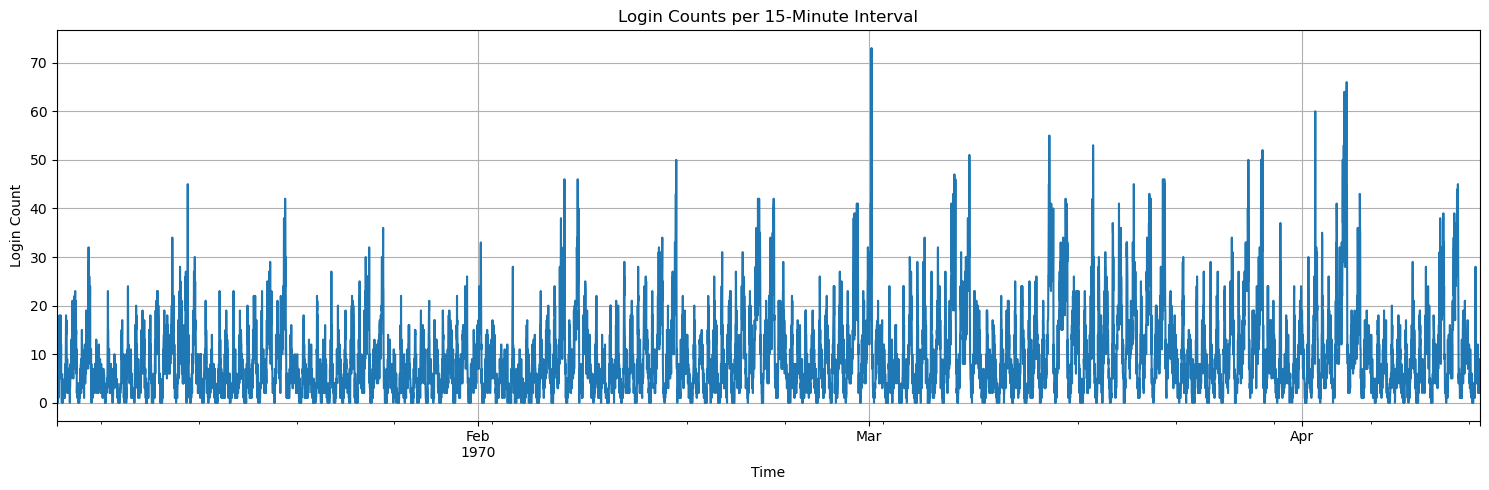

In [9]:
plt.figure(figsize=(15, 5))
login_counts.plot()
plt.title("Login Counts per 15-Minute Interval")
plt.xlabel("Time")
plt.ylabel("Login Count")
plt.grid(True)
plt.tight_layout()
plt.show()

## Explore Daily Patterns  (Deeper Analysis)

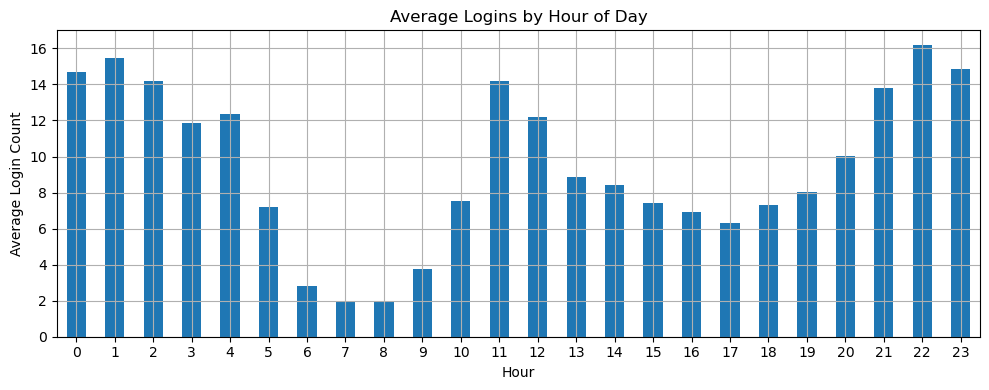

In [10]:
# Add helper columns
login_counts_df = login_counts.to_frame(name='count')
login_counts_df['hour'] = login_counts_df.index.hour
login_counts_df['dayofweek'] = login_counts_df.index.dayofweek  

# Average login count per hour across all days
hourly_avg = login_counts_df.groupby('hour')['count'].mean()

plt.figure(figsize=(10, 4))
hourly_avg.plot(kind='bar')
plt.title("Average Logins by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Login Count")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

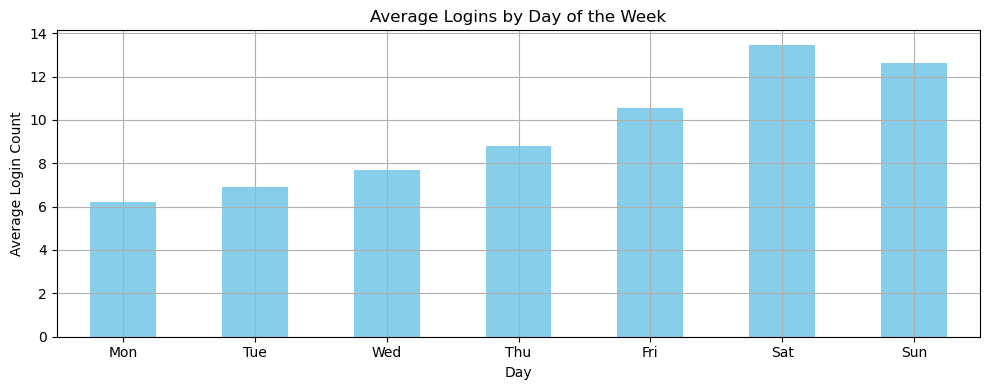

In [11]:
# Average login count per day of the week (0 = Monday, 6 = Sunday)
daily_avg = login_counts_df.groupby('dayofweek')['count'].mean()

# Map numbers to weekday names for readability
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(10, 4))
daily_avg.index = weekday_labels
daily_avg.plot(kind='bar', color='skyblue')
plt.title("Average Logins by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Average Login Count")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


## Check for Data Quality Issues

In [12]:
# Check for missing timestamps (gaps > 15 min)
time_diff = login_counts.index.to_series().diff()
gaps = time_diff[time_diff > pd.Timedelta("15T")]

print("Number of gaps longer than 15 minutes:", len(gaps))
print(gaps.head())

Number of gaps longer than 15 minutes: 0
Series([], Freq: 15T, Name: login_time, dtype: timedelta64[ns])


In [13]:
df2 = pd.read_json("ultimate_data_challenge.json")

In [18]:
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Part 2 – Experiment and Metrics Design

### 1) Key Measure of Success

The key metric I’d choose is the **number (or %) of cross-city trips per driver**.  
This directly shows if more drivers are working in both cities — which is the main goal of reimbursing tolls.

---

### 2) Experiment Design

#### a) Implementation

I’d run a **randomized controlled experiment**:

- **Split drivers** into two groups:  
  - **Treatment**: get tolls reimbursed  
  - **Control**: no change  
- Track how many cross-city trips each group makes over 4–6 weeks.
- Use GPS and trip data to measure behavior.

#### b) Statistical Test

I’d use a two-sample t-test to compare average cross-city trips between the groups.

If the p-value < 0.05, you reject the null hypothesis and conclude there is a significant difference between the two group means.

If the p-value ≥ 0.05, there's no strong evidence of a difference.


#### c) Interpretation

- If treatment drivers do **more** cross-city trips → program is **effective**, recommend expanding it.
- If no difference → tolls may not be


## Part 3 ‐ Predictive modeling

### Data Cleaning, Exploratory Analysis, and Visualizations

**Objective:** The goal of this part is to clean the dataset, define what a "retained" user is, and visualize the data to understand user behavior and key features.


Data loaded successfully.

DataFrame information and missing values after cleaning:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver  

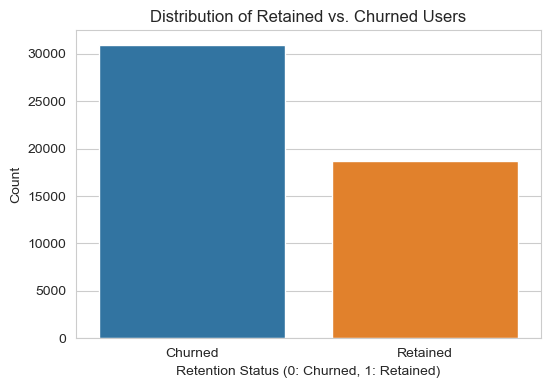

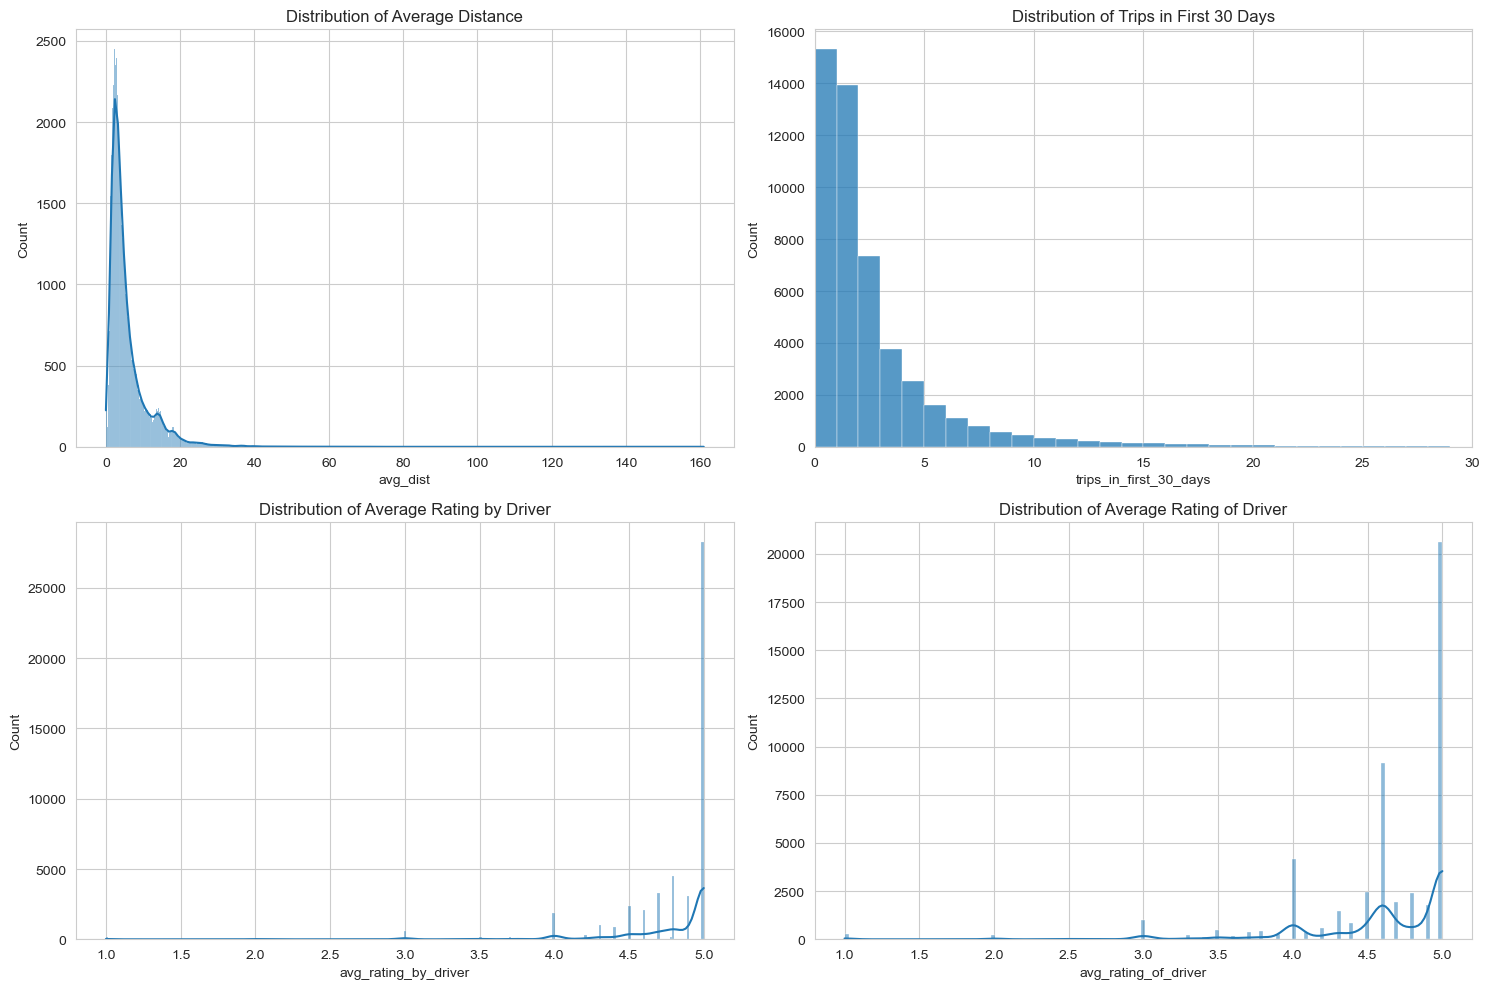

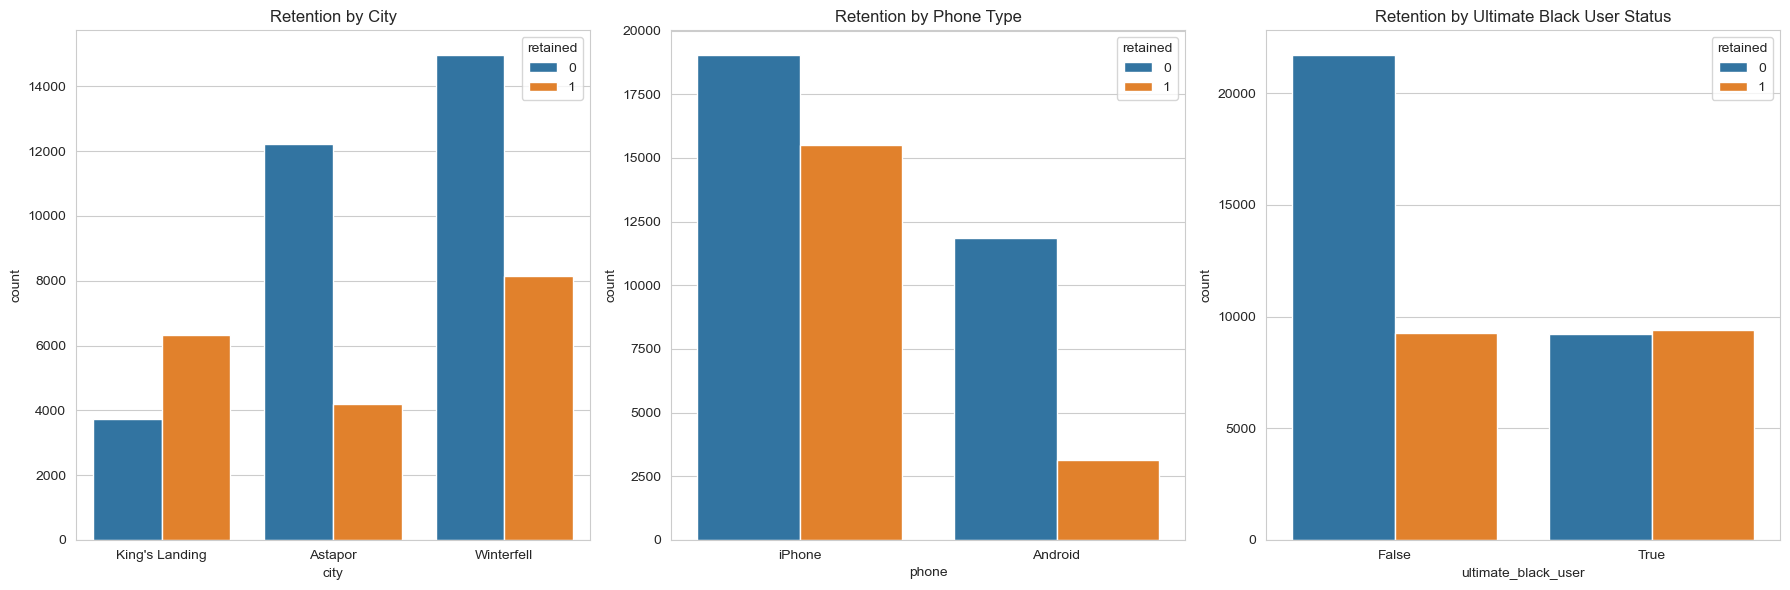

In [17]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style for better visuals
sns.set_style("whitegrid")

pd.set_option('display.max_columns', None)
np.random.seed(42)

# --- Data Loading and Cleaning ---
try:
    # Load the JSON data from the file
    file_path = "ultimate_data_challenge.json"
    with open(file_path, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    print("Data loaded successfully.")

    # Convert date columns to datetime objects
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

    # Define the retention target variable
    # A user is retained if they took a trip in the preceding 30 days.
    # The latest `last_trip_date` is '2014-07-01', so the "preceding 30 days" means from '2014-06-01' onwards.
    df['retained'] = (df['last_trip_date'] >= '2014-06-01').astype(int)

    # Handle missing values
    df.dropna(subset=['phone'], inplace=True)

    # Impute missing ratings with the mean
    df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
    df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

    print("\nDataFrame information and missing values after cleaning:")
    df.info()
    print("\nDescriptive Analysis of Features:")
    print(df.describe())

    # --- Visualizations ---
    print("\nVisualizations to explore key features and their relationship with retention:")

    # Distribution of the target variable
    plt.figure(figsize=(6, 4))
    sns.countplot(x='retained', data=df)
    plt.title('Distribution of Retained vs. Churned Users')
    plt.xlabel('Retention Status (0: Churned, 1: Retained)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Churned', 'Retained'])
    plt.show()
    plt.close()

    # Distributions of key numerical features
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    sns.histplot(df['avg_dist'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Average Distance')
    sns.histplot(df['trips_in_first_30_days'], bins=range(int(df['trips_in_first_30_days'].max()) + 2), kde=False, ax=axes[0, 1])
    axes[0, 1].set_title('Distribution of Trips in First 30 Days')
    axes[0, 1].set_xlim(0, 30)
    sns.histplot(df['avg_rating_by_driver'], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution of Average Rating by Driver')
    sns.histplot(df['avg_rating_of_driver'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Distribution of Average Rating of Driver')
    plt.tight_layout()
    plt.show()
    plt.close()

    # Categorical features vs. retention
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sns.countplot(x='city', hue='retained', data=df, ax=axes[0])
    axes[0].set_title('Retention by City')
    sns.countplot(x='phone', hue='retained', data=df, ax=axes[1])
    axes[1].set_title('Retention by Phone Type')
    sns.countplot(x='ultimate_black_user', hue='retained', data=df, ax=axes[2])
    axes[2].set_title('Retention by Ultimate Black User Status')
    plt.tight_layout()
    plt.show()
    plt.close()

except FileNotFoundError:
    print("The file 'ultimate_data_challenge.json' was not found in the environment. Please ensure it is uploaded.")
except Exception as e:
    print(f"An error occurred during the analysis: {e}")

### Building a Predictive Model

**Objective:** The goal is to build a model that can predict user retention and identify the most important factors influencing it.

**Approach:**

Feature Engineering: Categorical features (city, phone, ultimate_black_user) were converted to numerical values using one-hot encoding for the model.

Model Selection: A Random Forest Classifier was chosen due to its ability to handle different data types, capture non-linear relationships, and provide feature importance scores.

Training and Evaluation: The data was split into training and testing sets. The model was trained on the training data and evaluated on the test data using metrics like accuracy, precision, recall, F1-score, and ROC AUC. A confusion matrix and ROC curve were also generated to visualize performance.

Feature Importance: The model was used to rank the features based on their importance in predicting retention.

Model Performance & Concerns:

The model achieved an ROC AUC score of 0.82, which indicates it is effective at distinguishing between retained and churned users.

However, a key concern is that the model was trained on a single cohort (users who signed up in January 2014), so its performance may not generalize to future user cohorts or different time periods.


Model Performance Metrics:
Accuracy: 0.7501
Precision: 0.6760
Recall: 0.6454
F1-Score: 0.6604
ROC AUC Score: 0.8196

Confusion Matrix:
[[5032 1155]
 [1324 2410]]

Feature Importances (Top 10):
avg_dist                  0.306044
weekday_pct               0.127890
avg_rating_by_driver      0.121081
avg_rating_of_driver      0.080037
trips_in_first_30_days    0.077694
surge_pct                 0.075325
city_King's Landing       0.065589
avg_surge                 0.063446
phone_iPhone              0.038164
ultimate_black_user       0.028866
dtype: float64


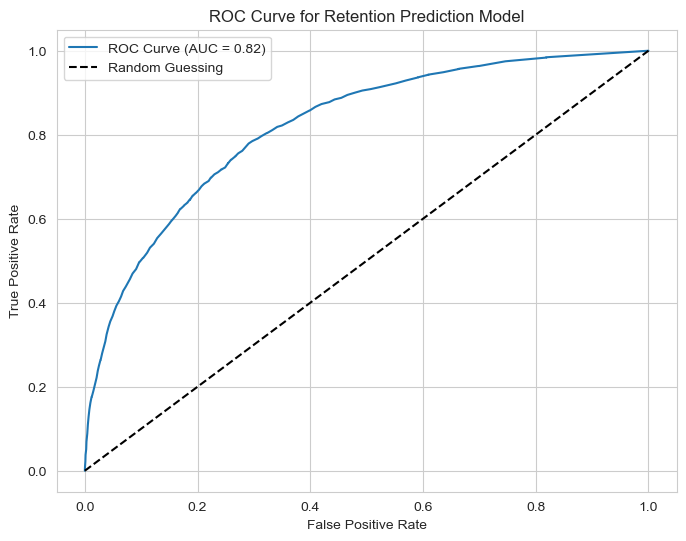

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

df_model = df.copy()

# Feature Engineering for the model
# Convert categorical features to dummy variables
df_model['ultimate_black_user'] = df_model['ultimate_black_user'].astype(int)
df_model = pd.get_dummies(df_model, columns=['city', 'phone'], drop_first=True)

# Drop the date columns as they are not needed for the model
df_model.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

# Define features (X) and target (y)
X = df_model.drop('retained', axis=1)
y = df_model['retained']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model Selection: Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importance
print("\nFeature Importances (Top 10):")
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances.head(10))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Retention Prediction Model')
plt.legend()
plt.show()
plt.close()